In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np

import xarray as xr

import regionmask

import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy.feature as cfeat
import matplotlib.patches as mpatches
import cmocean

import glob


import sys
sys.path.append('../')
import utils
import plotting

np.seterr(invalid='ignore'); # disable a warning from matplotlib and cartopy

# Import Data

In [2]:
ds= xr.open_dataset('./final_data/ds_NOX_SO2_CH2O_daily.nc4')
ds_seasonal = utils.season_mean(ds)
for p in ['NO2','NOx','NO','SO2','CH2O']:
    ds_seasonal[p].attrs = {'units':'ppb'}
    
model_names = ds['model_name'].values


# Plots

## US, concentrations

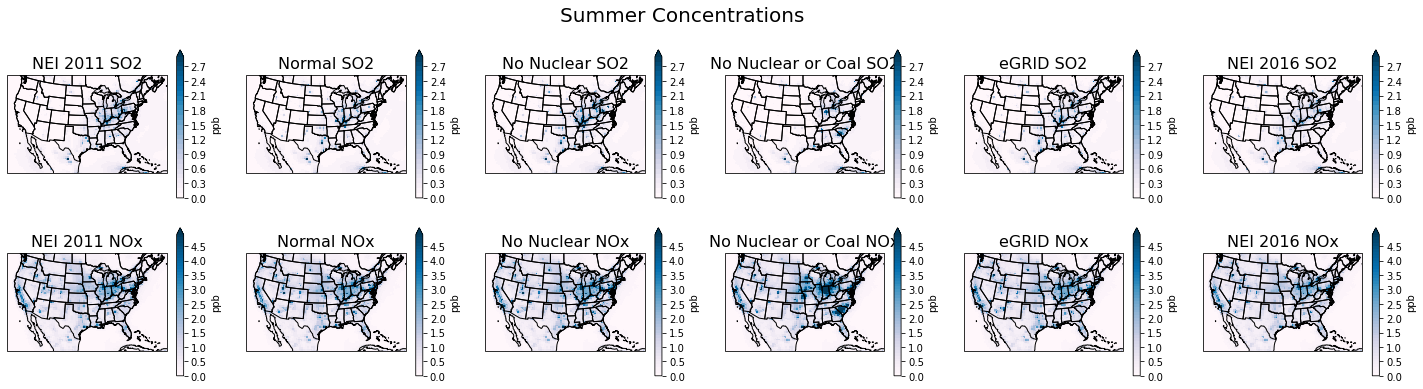

In [3]:
plotting.concentration_plot_seasonal(ds_seasonal = ds_seasonal, species_names = ['SO2','NOx'], season = 'JJA', model_names = model_names,  cmap = plotting.cmap_conc,
                        lat_lon = [-120,-70,20,50], shrink_cbar = 1,
                       figsize = [25,6])
plt.suptitle('Summer Concentrations', fontsize = 20);
#plt.savefig('./Figures/supp_summer_conc.png',bbox_inches = 'tight', dpi = 150)

## US, differences Normal and No Nuclear

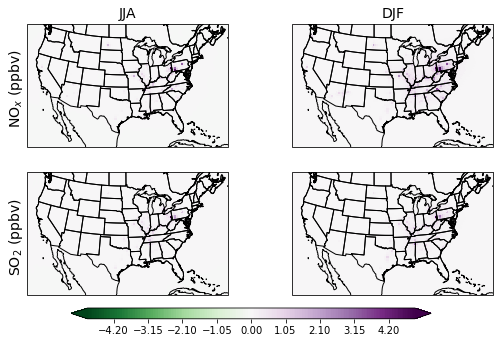

In [7]:
plotting.concentration_plot_seasonal_dif(ds_seasonal = ds_seasonal, seasons = ['JJA','DJF'], species_names = ['NOx','SO2'], cmap = plotting.cmap_dif, 
                                         mod_base = 'normal_NA', mod_delta = 'nonuc_NA',
                   rows = 2, columns = 2, levels = np.arange(-5.,5.05,.05), lat_lon = [-120,-70,20,50],
                   figsize = [10, 5], extension = 'both')
plt.savefig('./Figures/nox_so2_dif.png', bbox_inches = 'tight', dpi = 150)

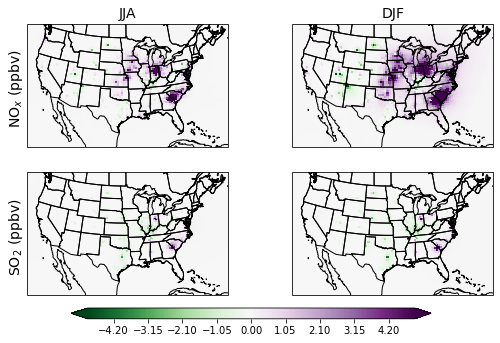

In [5]:
plotting.concentration_plot_seasonal_dif(ds_seasonal = ds_seasonal, seasons = ['JJA','DJF'], species_names = ['NOx','SO2'], cmap = plotting.cmap_dif, 
                                         mod_base = 'normal_NA', mod_delta = 'nonuc_coal_NA',
                   rows = 2, columns = 2, levels = np.arange(-5.,5.05,.05), lat_lon = [-120,-70,20,50],
                   figsize = [10, 5], extension = 'both')
plt.savefig('./Figures/nox_so2_dif_nocoal.png', bbox_inches = 'tight', dpi = 150)

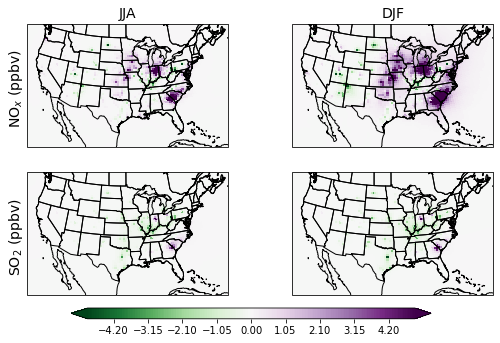

In [6]:
plotting.concentration_plot_seasonal_dif(ds_seasonal = ds_seasonal, seasons = ['JJA','DJF'], species_names = ['NOx','SO2'], cmap = plotting.cmap_dif, 
                                         mod_base = 'nonuc_NA', mod_delta = 'nonuc_coal_NA',
                   rows = 2, columns = 2, levels = np.arange(-5.,5.05,.05), lat_lon = [-120,-70,20,50],
                   figsize = [10, 5], extension = 'both')
#plt.savefig('./Figures/nox_so2_dif_nocoal.png', bbox_inches = 'tight', dpi = 150)